## IBM Applied Data Science Capstone Project
#### Onur Başar, 03/23/2021

### 1. Introduction

This project aims to analyze locational data using web scraping and APIs methods corresponds to IBM Data Science Capstone Project. In this project, we will analyze the venues of three big cities, namely Toronto, New York and Berlin. 
Imagine that you just finished your bachelor programm and you want to register a Master programm in one of this 3 big cities. In the matter of education quality, 3 big cities have equal education quality. What you want explore is that the venues of this cities. For example, how many libraries, caffee shops, sport events, concerts etc. are there? And of course, how much money do you need in order to pay your rents and sustain your life. We will compare the venues and costs, and we will try to choose a city based on our properties in the conclusion.

### 2. Data

1. Foursquare: Foursquare is an American technology company which location platform is the foundation of several business and consumer products, including the Foursquare City Guide and Foursquare Swarm apps. The Places API offers real-time access to Foursquare’s global database of rich venue data and user content to power your location-based experiences in your app or website. In the project, we will use Foursquare API in order to retrieve venues of locations.
2. Wikipedia: Wikipedia is a free multilingual wiki-based online encyclopedia edited and maintained by a community of volunteer editors. We will use web scraping on Wikipedia web page in order to get the postal codes or addresses of cities. 

In [2]:
# Essential libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
from geopy.geocoders import Nominatim 
from pandas.io.json import json_normalize
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
print("Libraries loaded")

Libraries loaded


### 3. Metholodogy

In [48]:
CLIENT_ID = 'EOSYQUCMVOTJYW1S2RPLVZQTCVVTQQJB12IXQADPRKEXUIIQ'
CLIENT_SECRET = 'LNBUUHZDQMD1TBF2EL0NUMM2MGUCX4INKZPVPKXYTVTFEUYG'
access_token = "TH1NGK1VGJIADCQVJAI0XOVLBT2IKAKV4XZYXWBVWVKPF41O"
VERSION = '20180604'
LIMIT = 100

In [49]:
address = 'Straße des 17. Juni 135, 10623 Berlin, Deutschland' # address of Technical University of Berlin

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

52.510942 13.3287375


In [50]:
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [51]:
results = requestsests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '605a30f3c87eac36810e6f03'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Hardenbergstraße',
  'headerFullLocation': 'Hardenbergstraße, Berlin',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 176,
  'suggestedBounds': {'ne': {'lat': 52.51994200900001,
    'lng': 13.343497701622953},
   'sw': {'lat': 52.50194199099999, 'lng': 13.313977298377049}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52651915498efbb22b314e60',
       'name': 'Hotel am Steinplatz',
       'location': {'address': 'Steinplatz 4',
        'lat': 52.508074,
        'lng': 13.326501,
        'labeledLatLngs': [{'label': 'display',
          'lat': 52.5080

In [52]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [53]:
items = results['response']['groups'][0]['items']
dataframe = json_normalize(items) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head()

<ipython-input-53-0cdb9ddad72a>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(items) # flatten JSON


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Hotel am Steinplatz,Hotel,Steinplatz 4,52.508074,13.326501,"[{'label': 'display', 'lat': 52.508074, 'lng':...",353,10623,DE,Berlin,Berlin,Deutschland,"[Steinplatz 4, 10623 Berlin, Deutschland]",NaN,NaN,52651915498efbb22b314e60
1,Manufactum Warenhaus,Furniture / Home Store,Hardenbergstr. 4-5,52.511153,13.322806,"[{'label': 'display', 'lat': 52.51115322060605...",402,10623,DE,Charlottenburg,Berlin,Deutschland,"[Hardenbergstr. 4-5, 10623 Charlottenburg, Deu...",NaN,NaN,5679654d498e19c3c12a26c3
2,Zirkus Flic Flac,Circus,Hertzallee,52.509947,13.333232,"[{'label': 'display', 'lat': 52.50994675493646...",324,NaN,DE,Berlin,Berlin,Deutschland,"[Hertzallee, Berlin, Deutschland]",NaN,NaN,580ba44938fa693d96a15b60
3,C/O Berlin,Art Museum,Hardenbergstr. 22-24,52.506784,13.330789,"[{'label': 'display', 'lat': 52.50678358537336...",483,10623,DE,Berlin,Berlin,Deutschland,"[Hardenbergstr. 22-24, 10623 Berlin, Deutschland]",NaN,NaN,5228b7737e484ee899dce79b
4,Restaurantschiff Capt. Schillow,German Restaurant,Straße des 17. Juni 113,52.512683,13.331891,"[{'label': 'display', 'lat': 52.51268263602812...",288,10623,DE,Berlin,Berlin,Deutschland,"[Straße des 17. Juni 113, 10623 Berlin, Deutsc...",NaN,NaN,4bb88c8d7421a59374dcc140


In [54]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='purple',
        fill_color='purple',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

In [55]:
dataframe_filtered.iat[4, 1]

'German Restaurant'

In [108]:
def updateCategories(dataframe_filtered):
    for i in range(27):
        if "Restaurant" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Restaurant"
        elif "Theater" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Theater"
        elif "Caf" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Cafe"
        elif "Zoo" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Zoo"
        elif "Museum" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Museum"
        elif "Bar" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Bar"
        elif "Coffee" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Cafe"
        elif "Pizza" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Restaurant"
        elif "Burger" in str(dataframe_filtered.iat[i, 1]):
            dataframe_filtered.iat[i, 1] = "Restaurant"

In [88]:
dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,neighborhood,id
0,Hotel am Steinplatz,Hotel,Steinplatz 4,52.508074,13.326501,"[{'label': 'display', 'lat': 52.508074, 'lng':...",353,10623,DE,Berlin,Berlin,Deutschland,"[Steinplatz 4, 10623 Berlin, Deutschland]",NaN,NaN,52651915498efbb22b314e60
1,Manufactum Warenhaus,Furniture / Home Store,Hardenbergstr. 4-5,52.511153,13.322806,"[{'label': 'display', 'lat': 52.51115322060605...",402,10623,DE,Charlottenburg,Berlin,Deutschland,"[Hardenbergstr. 4-5, 10623 Charlottenburg, Deu...",NaN,NaN,5679654d498e19c3c12a26c3
2,Zirkus Flic Flac,Circus,Hertzallee,52.509947,13.333232,"[{'label': 'display', 'lat': 52.50994675493646...",324,NaN,DE,Berlin,Berlin,Deutschland,"[Hertzallee, Berlin, Deutschland]",NaN,NaN,580ba44938fa693d96a15b60
3,C/O Berlin,Museum,Hardenbergstr. 22-24,52.506784,13.330789,"[{'label': 'display', 'lat': 52.50678358537336...",483,10623,DE,Berlin,Berlin,Deutschland,"[Hardenbergstr. 22-24, 10623 Berlin, Deutschland]",NaN,NaN,5228b7737e484ee899dce79b
4,Restaurantschiff Capt. Schillow,Restaurant,Straße des 17. Juni 113,52.512683,13.331891,"[{'label': 'display', 'lat': 52.51268263602812...",288,10623,DE,Berlin,Berlin,Deutschland,"[Straße des 17. Juni 113, 10623 Berlin, Deutsc...",NaN,NaN,4bb88c8d7421a59374dcc140


<AxesSubplot:xlabel='categories'>

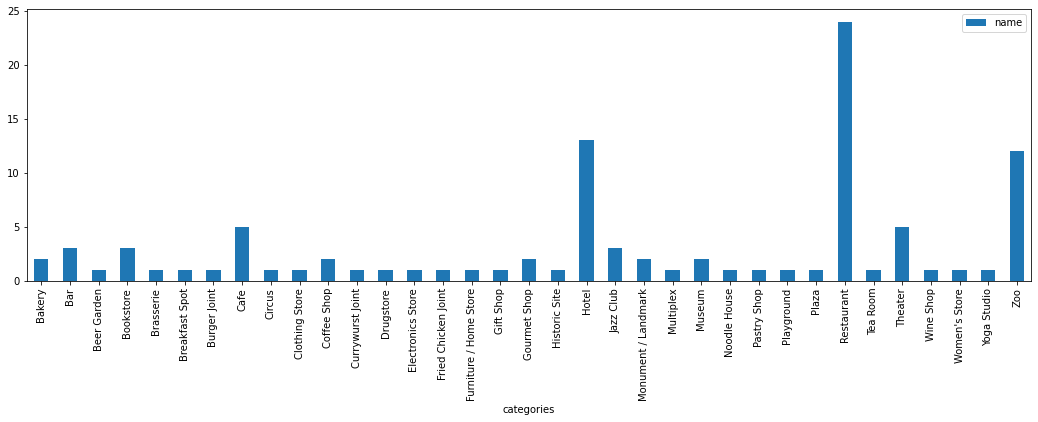

In [89]:
dataframe_filtered.groupby(['categories']).count().plot.bar(y='name', figsize=(18, 5))

In [93]:
address2 = '4700 Keele St, Toronto, ON M3J 1P3, Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address2)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.7733022 -79.4938255


In [94]:
radius2 = 1000
url2 = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

In [95]:
results2 = requests.get(url2).json()
results2

{'meta': {'code': 200, 'requestId': '605a34a2646f09389204732c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 27,
  'suggestedBounds': {'ne': {'lat': 43.782302209000015,
    'lng': -79.48138481224689},
   'sw': {'lat': 43.76430219099999, 'lng': -79.50626618775311}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d617a7829ef236a606fb159',
       'name': 'Bamiyan Kabob',
       'location': {'address': '4205 Keele St.',
        'lat': 43.773768556446406,
        'lng': -79.49274051998997,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.773768556446406,
       

In [112]:
items2 = results2['response']['groups'][0]['items']
dataframe = json_normalize(items2) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# filter the category for each row
dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean columns
dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

dataframe_filtered.head()

<ipython-input-112-5e2b53904466>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(items2) # flatten JSON


,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Bamiyan Kabob,Middle Eastern Restaurant,4205 Keele St.,43.773769,-79.492741,"[{'label': 'display', 'lat': 43.77376855644640...",101,M3J 3T8,CA,Toronto,ON,Canada,"[4205 Keele St., Toronto ON M3J 3T8, Canada]",NaN,4d617a7829ef236a606fb159
1,MUSE Massage Spa,Massage Studio,13-1290 Finch Ave. W.,43.765686,-79.489318,"[{'label': 'display', 'lat': 43.7656861872247,...",921,M3J 3K3,CA,Toronto,ON,Canada,"[13-1290 Finch Ave. W. (at Keele St.), Toronto...",at Keele St.,4d3599d2eefa8cfa141d56b3
2,Long & McQuade Musical Instruments,Music Store,2777 Steeles Ave W,43.781419,-79.490503,"[{'label': 'display', 'lat': 43.78141890254774...",942,M3J 3K5,CA,North York,ON,Canada,"[2777 Steeles Ave W, North York ON M3J 3K5, Ca...",NaN,4b522e7df964a520ec6d27e3
3,Absinthe Pub and Coffee Shop,Pub,4700 Keele St,43.776412,-79.501995,"[{'label': 'display', 'lat': 43.77641202695796...",742,NaN,CA,Toronto,ON,Canada,"[4700 Keele St (Keele and Steeles), Toronto ON...",Keele and Steeles,4b0c25b5f964a520ce3723e3
4,Thai Express,Restaurant,"4700 Keele St, York Lanes",43.773536,-79.501941,"[{'label': 'display', 'lat': 43.773536, 'lng':...",652,M3J 1P3,CA,Toronto,ON,Canada,"[4700 Keele St, York Lanes, Toronto ON M3J 1P3...",NaN,5216459b11d2eea0000d774d


In [98]:
venues_map = folium.Map(location=[latitude, longitude], zoom_start=15) # generate map centred around Ecco


# add Ecco as a red circle mark
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    popup='Ecco',
    fill=True,
    color='red',
    fill_color='red',
    fill_opacity=0.6
    ).add_to(venues_map)


# add popular spots to the map as blue circle markers
for lat, lng, label in zip(dataframe_filtered.lat, dataframe_filtered.lng, dataframe_filtered.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='purple',
        fill_color='purple',
        fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

In [141]:
updateCategories(dataframe_filtered)
dataframe_filtered.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,crossStreet,id
0,Bamiyan Kabob,Restaurant,4205 Keele St.,43.773769,-79.492741,"[{'label': 'display', 'lat': 43.77376855644640...",101,M3J 3T8,CA,Toronto,ON,Canada,"[4205 Keele St., Toronto ON M3J 3T8, Canada]",NaN,4d617a7829ef236a606fb159
1,MUSE Massage Spa,Massage Studio,13-1290 Finch Ave. W.,43.765686,-79.489318,"[{'label': 'display', 'lat': 43.7656861872247,...",921,M3J 3K3,CA,Toronto,ON,Canada,"[13-1290 Finch Ave. W. (at Keele St.), Toronto...",at Keele St.,4d3599d2eefa8cfa141d56b3
2,Long & McQuade Musical Instruments,Music Store,2777 Steeles Ave W,43.781419,-79.490503,"[{'label': 'display', 'lat': 43.78141890254774...",942,M3J 3K5,CA,North York,ON,Canada,"[2777 Steeles Ave W, North York ON M3J 3K5, Ca...",NaN,4b522e7df964a520ec6d27e3
3,Absinthe Pub and Coffee Shop,Pub,4700 Keele St,43.776412,-79.501995,"[{'label': 'display', 'lat': 43.77641202695796...",742,NaN,CA,Toronto,ON,Canada,"[4700 Keele St (Keele and Steeles), Toronto ON...",Keele and Steeles,4b0c25b5f964a520ce3723e3
4,Thai Express,Restaurant,"4700 Keele St, York Lanes",43.773536,-79.501941,"[{'label': 'display', 'lat': 43.773536, 'lng':...",652,M3J 1P3,CA,Toronto,ON,Canada,"[4700 Keele St, York Lanes, Toronto ON M3J 1P3...",NaN,5216459b11d2eea0000d774d


<AxesSubplot:xlabel='categories'>

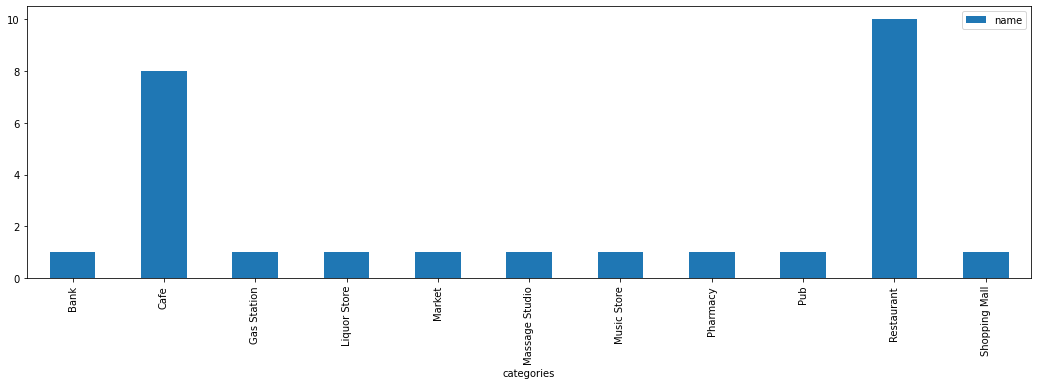

In [111]:
dataframe_filtered.groupby(['categories']).count().plot.bar(y='name', figsize=(18, 5))

### 3.2 Clustering

In [114]:
source = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").text
soup = BeautifulSoup(source, 'xml')
table=soup.find('table')
column_names = ['Postalcode','Borough','Neighborhood']
df = pd.DataFrame(columns = column_names)

In [115]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

In [116]:
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [138]:
df.head(10)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills North,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [118]:
pip install geocoder

Note: you may need to restart the kernel to use updated packages.


In [119]:
url='https://cocl.us/Geospatial_data/Geospatial_Coordinates.csv'
df_coordinates=pd.read_csv(url)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [120]:
df = df.rename(columns = {'PostalCode':'Postal Code'}) 

In [121]:
df = pd.merge(df, df_coordinates, on = 'Postal Code')
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [122]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [123]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills North
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills South
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East
The Danforth

In [124]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
Willowdale West,4,4,4,4,4,4
"Willowdale, Newtonbrook",1,1,1,1,1,1
Woburn,3,3,3,3,3,3


In [127]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()


,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [139]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Truck Stop,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [131]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Breakfast Spot,Lounge,Latin American Restaurant,Skating Rink,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,"Alderwood, Long Branch",Pizza Place,Skating Rink,Dance Studio,Gym,Coffee Shop,Sandwich Place,Pub,Pool,Women's Store,Distribution Center
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Diner,Deli / Bodega,Supermarket,Ice Cream Shop,Sushi Restaurant,Intersection,Middle Eastern Restaurant,Restaurant
3,Bayview Village,Café,Chinese Restaurant,Japanese Restaurant,Bank,Women's Store,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Sandwich Place,Italian Restaurant,Coffee Shop,Comfort Food Restaurant,Pizza Place,Locksmith,Juice Bar,Fast Food Restaurant,Restaurant,Butcher


In [132]:
kclusters = 3
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

In [137]:
#neighborhoods_venues_sorted.insert(0, 'ClusterLabel', kmeans.labels_)

toronto_merged = df
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged = toronto_merged.dropna()
toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,ClusterLabel,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,2.0,Food & Drink Shop,Park,Construction & Landscaping,Women's Store,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Hockey Arena,French Restaurant,Pizza Place,Coffee Shop,Portuguese Restaurant,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,1.0,Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Café,Theater,French Restaurant,Historic Site,Spa
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,Clothing Store,Furniture / Home Store,Women's Store,Accessories Store,Vietnamese Restaurant,Boutique,Arts & Crafts Store,Coffee Shop,Donut Shop,Discount Store
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,1.0,Coffee Shop,College Cafeteria,Sushi Restaurant,Yoga Studio,Bar,Beer Bar,Smoothie Shop,Sandwich Place,Burger Joint,Burrito Place


In [134]:
address = 'Toronto'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [135]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['ClusterLabel']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 4. Results

In the data exploration above, we realize that there are less venues around the University of York compare to the University of Berlin. The most common venue for both location is restaurants, following by cafes. Our radius for both location was 1000 meters. But we were able to find less venues around York University. We can clearly say that there are more competition around Technical University of Berlin compare to York University. For that reason, it is more reasonable to study in York University. During the education, we can explore places that we can open our restaurants and get knowledge and insights of the people and tradition of the place. For example, we can find out whether they like Taiwan food more, or American fast food. Based on these insights, we can pick up foods for our restaurants.

In the second step, we analyze the neighborhoods in Toronto. We used clustering and we found that most of venues are in the same cluster (purple). Also, we can say that the venues in the red cluster are way far from the center of Toronto. It would be good idea to pick the place from cyan cluster, because of the fact that this cluster have less venues compare to purple cluster, and not far to city center as red cluster.


### 5. Discussion

Based on the results above, I recommend that when you want to open a restaurant, you have to check the venues in that city. How many restaurants, cafes, pubs this city have? How can you choose the best restaurants, in order to deal less competition? You can use Foursquare API and clustering in order to obtain venues and cluster venues by their specific categories. 

If you want to open a restaurant whether in Berlin or in Toronto, Toronto would be better idea.


### 6. Conclusion

In this project, we use Foursquare API and Python clustering in order to explore and analyze venues around York University, Toronto and Technical University of Berlin, Berlin. We made a conclusion based on our analyze whether we should open restaurant in Berlin, or in Toronto. Thank you for your time and attention.